## Project
### Selecting a region for oil extraction

*Background:*

An oil company plans to invest into its further expansion. For this, it has to choose a region for oil extraction among the three different countries.

*Tasks:*
- build a model for predicting the reserves in available wells;
- determine the region with the maximum expected profit from oil production.

*Conditions:*
- when exploring the region, it is possible to only explore 500 wells, from which machine learning is used to select the top 200 for development;
- The budget for well development in the region is 10 billion rubles (~114M EUR).
- A barrel of oil costs 450 rubles (~5.11 EUR).
- When selecting the region, we need:
    - to estimate the risks of making a loss for a given region and to consider only those regions that have a loss probability less than 2.5%;
    - then, to choose the region with the highest average profit among them.

-----
----

## Executive Summary 
       
**Recommendation:** `Region 2`
    
- Region 2 is the only one that demonstrated a loss risk level below the maximum allowed value of 2.5%.
- The expected profit from oil production in this region is 430 million rubles.

**Modeling approach:**
- to predict the volume of oil in the deposits, a linear regression was used to ensure the interpretability of result;
- to build the distribution of potential profits in each of the regions, the Bootstrap technique with 1000 iterations was applied.

---
---

#### Table of Contents

1. [General information and data preprocessing](#paragraph1)
2. [Traning the model](#paragraph2)    
3. [Preparing for profit calculations](#paragraph3)   
4. [Calculating loss risk and expected profit](#paragraph4)       
5. [Final Summary](#paragraph5)

---

Importing the libraries

In [1]:
import pandas as pd
import numpy as np

# for preparing the data for modelling
from sklearn.model_selection import train_test_split

# for modelling
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression

# for model quality estimation
from sklearn.metrics import mean_squared_error

# for confidence interval calculation
from scipy import stats as st

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

Preparing the notebook

In [2]:
# saving the variable for addressing the global variables
gbl = globals()

# ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# centering outputs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### 1. General information and data preprocessing <a name="paragraph1"></a>

For analysis, we have got three datasets containing data on oil deposits in (correspondingly) three regions.

- `id` is a unique identifier of an oil deposit;
- `f0`,` f1`, `f2` are three parameters of an oil deposit (we do not know exactly what each of them mean but they should be an, allegedly, important predictor with the oil reserve volumes);
- `product` is the volume of oil reserves in an oil deposit (thousands of barrels).

Next steps:
1. to display general information about variables and datasets;
2. screen the datasets for presence of:
    - duplicates;
    - missing values;
    - strange (out-of-format/range) values of variables.

Uploading Data

In [3]:
data_1 = pd.read_csv('geo_data_0.csv')
data_2 = pd.read_csv('geo_data_1.csv')
data_3 = pd.read_csv('geo_data_2.csv')

# setting up a list of datasets
datasets = [data_1, data_2, data_3]

#### 1.1. General information

In [4]:
for data in datasets:
    data.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

Deleting the variable `id` as it does not provide any menaingful insights

In [5]:
for i in [1, 2, 3]:
    gbl['data_' + str(i)] = gbl['data_' + str(i)].drop('id', axis=1)

#### 1.2. General analysis of datasets

#### Checking for duplicates

In [6]:
n = 0
for data in datasets:
    n += 1
    print('Number of duplicates in the dataset №{:.0f}:'.format(n), data.duplicated().sum())

Number of duplicates in the dataset №1: 0
Number of duplicates in the dataset №2: 0
Number of duplicates in the dataset №3: 0


#### Checking for strange (out-of-format/range) values

Let's draw graphs on the distribution density of variables

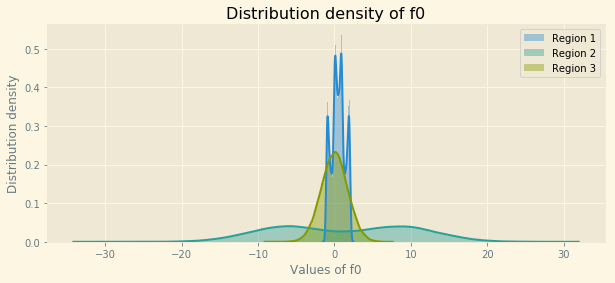

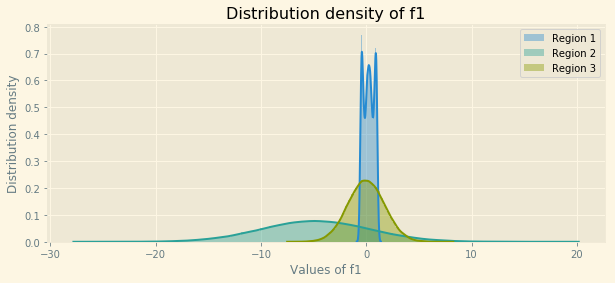

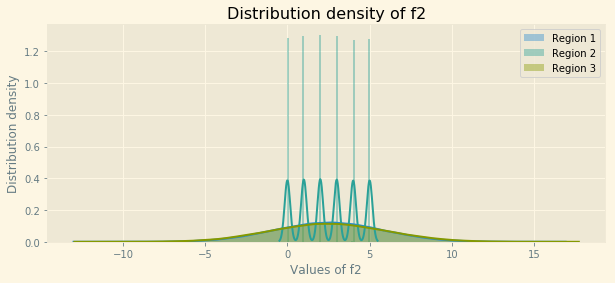

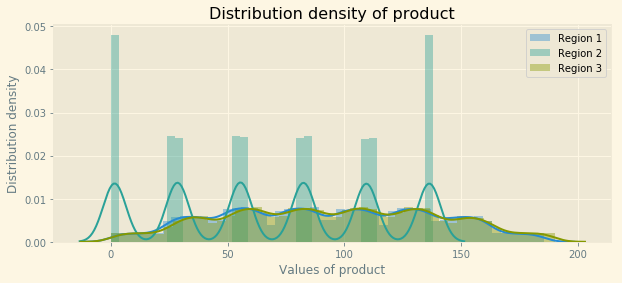

In [7]:
plt.style.use('Solarize_Light2')
for var in ['f0', 'f1', 'f2', 'product']:
    n = 0
    fig, ax = plt.subplots(figsize=(10,4))
    for data in datasets:
        n += 1
        ax = sns.distplot(data[var], label='Region {:.0f}'.format(n))
    ax.set(title='Distribution density of ' + var,
       xlabel='Values of ' + var, ylabel='Distribution density')
    ax.legend()
    plt.show()    

---
**Interim Analysis:**
- regions differ quite dramatically in the distribution of metrics `f0` and `f1` (both in averages and in variances);
- the values of `f2` in Regions 1 and 3 are very similarly distributed (as well as the target feature is `product`); however, Region 2 is remarkably different along the parameters under consideration;
- let's build separate models for each region.

---

### 2. Training the model <a name="paragraph2"></a>

#### 2.1. Splitting into training and testing samples

Forming training and testing samples for each region-dataset in a ratio 75:25

In [8]:
state = RandomState(123456)

n = 0
for dataset in datasets:
    n += 1
    target = dataset['product']
    features = dataset.drop(['product', 'id'], axis=1)
    gbl['features_train_'+str(n)], gbl['features_valid_'+str(n)], gbl['target_train_'+str(n)], gbl['target_valid_'+str(n)] = train_test_split(features, target, test_size=0.25, random_state=state)    

#### 2.2. Training models for each region

After training the model on the training sample, we will predict the values on the testing samples and save the predictions for further analysis. The quality of the models will be estimated based on the root mean square error (RMSE).

In [9]:
for i in range(1, 4):
    gbl['model_'+str(i)] = LinearRegression()
    # training models
    gbl['model_'+str(i)].fit(gbl['features_train_'+str(i)], gbl['target_train_'+str(i)])
    
    # predicting values on testing dataset
    gbl['predictions_'+str(i)] = gbl['model_'+str(i)].predict(gbl['features_valid_'+str(i)])
    
    # saving predictions in Series and assigning a corresponsing index
    gbl['predictions_'+str(i)] = pd.Series(gbl['predictions_'+str(i)])
    gbl['predictions_'+str(i)].index = gbl['features_valid_'+str(i)].index
    
    # saving model quality for each region (model)
    gbl['score_'+str(i)] = mean_squared_error(gbl['predictions_'+str(i)], gbl['target_valid_'+str(i)]) ** 0.5

#### 2.3. Average predicted oil deposit volumes and RMSE of models

Ranking the final table according to the quality of the model

In [10]:
table = pd.DataFrame({'Region':[1, 2, 3], 
                      'Avg. oil volume per deposit, `000 of barrels.':[predictions_1.mean(), predictions_2.mean(), predictions_3.mean()], 
                      'RMSE':[score_1, score_2, score_3]})
table.set_index('Region').round(2).sort_values('RMSE')

,"Avg. oil volume per deposit, `000 of barrels.",RMSE
Region,,
2,68.48,0.89
1,92.49,37.80
3,95.13,40.18


---

**Interim Results**

- **The largest average volume per deposit**. The largest average volume per well is in the 1st and 3rd regions. In the 2nd, on average the volume of oil per well is 35% lower than in other regions.

- **Better predictability.** The model predicts volumes significantly better in the 2nd region. Quality metric is 42 times better than in the next best Region №1.

- **Comment:** it is still difficult to say which region should be chosen for development. On the one hand, the 2nd region attracts with its predictability and, accordingly, a higher probability of finding really rich deposits. But on the other hand, the average reserve per well is significantly higher in other two regions, and perhaps, even if we are mistaken in our predictions, we will be able to extract more oil on average.

---

### 3. Preparation for calculating profit <a name="paragraph3"></a>

#### 3.1. Defining key variables for calculating the profits

In [11]:
# budget in rubles
BUDGET = 10000000000

# price per 1000 barrels
PRICE = 450000

# number of well to be developed
WELLS_MAX = 200

#### 3.2. Calculating the break-even volume of oil reserves

Formula for calculating the minimum total volume of oil produced in a region to break even:

$$volume_{min} = \frac{budget}{price}$$

Formula for calculating the minimum average oil volume per well to break even:

$$volume_{per well, min} = \frac{budget}{price * wells}$$

*Assumption:* our costs correspond to the entire budget.

In [12]:
volume_min = BUDGET / PRICE
print('Minimum production volume to break-even: {:.2f} thousand barrels'.format(volume_min))

volume_perwell_min = BUDGET / PRICE / WELLS_MAX
print('Minimum average volume of produced oil per well: {:.2f} thousand barrels'.format(volume_perwell_min))

Minimum production volume to break-even: 22222.22 thousand barrels
Minimum average volume of produced oil per well: 111.11 thousand barrels


---

**Interim Summary**

- On average, each well must produce about 111 thousand barrels to break even.
- The average predicted oil volume per deposit in each region is 14-49% lower than what is needed to break even.
- This means that our model(s) should be able to find oil deposits that will give more than 111,000 barrels per deposit on average.

--- 

### 4. Calculating loss risk and expected profit <a name="paragraph4"></a>

#### 4.1. Defining function to calculate expected profit

Let's write a function which

1. receives a list of wells `wells _sample` as the input;
- selects X wells with maximum predicted oil reserves; X is equal to `WELLS_MAX` (in our case 200);
- sums the actual oil reserves corresponding to the selected wells; data on the real reserves of each well is taken from the corresponding original dataset; `wells_all_real` collects already all real values on reserves;
- calculates the total revenues by multiplying the real volume ofanproduction by the price of thousand barrels (`PRICE`);
- calculates profit by subtracting costs from revenues; we make the assumption that the cost of researching 500 and drilling 200 wells equals exactly the whole budget (`BUDGET`);
- provides calculated profit as the output.

In [13]:
def profit_calculator(wells_all_real, wells_sample, WELLS_MAX, BUDGET, PRICE):
    # taking the 200 most rich oil deposits (the ones which are predicted as being the most rich by our models)
    wells_best = wells_sample.sort_values(ascending=False)[:WELLS_MAX]
    
    # calculating total real oil reserves
    volume_total = wells_all_real[wells_best.index].sum()
    
    # calculating the profit
    profit = volume_total * PRICE - BUDGET
    return profit

#### 4.2. Calculating potential profit and loss risks for each region

*Calculating the following for each region based on the test samples:*
- distribution of profit using Bootstrap on 1000 subsamples;
- expected potential profit in the region;
- confidence interval for the average profit in the region (with 95% confidence level);
- the risk of losses.

*Comment:* the risk of making losses corresponds to [1] the percentile of the smallest loss (= negative profit) or, equivalently, [2] the share of losses (= negative values) in the distribution of profit values. We will use definition [2] to calculate the risk of losses as it is easier (and faster) in terms of calculation.

In [14]:
for n in [1, 2, 3]:
    gbl['profit_' + str(n)] = []
    state1 = RandomState(n+1234)
    
    # сформируем распределение возможной прибыли для каждого региона
    for k in range(0, 1000):
        wells_sample = gbl['predictions_' + str(n)].sample(500, random_state=state1, replace=True)
        profit = profit_calculator(gbl['target_valid_' + str(n)], wells_sample, WELLS_MAX, BUDGET, PRICE)
        gbl['profit_' + str(n)].append(profit)
        
    gbl['profit_' + str(n)] = pd.Series(gbl['profit_' + str(n)]) / 1000000
    
    # доверительный интвервал, в миллионах руб.
    gbl['confidence_interval_' + str(n)] = gbl['profit_' + str(n)].quantile([0.025, 0.975]).round(2)
    
    # среднее, в миллионах руб.
    gbl['profits_mean_' + str(n)] = round(gbl['profit_' + str(n)].mean(), 2)
    
    # оценка риска
    gbl['loss_risk_' + str(n)] = (gbl['profit_' + str(n)] < 0).mean()

#### 4.3. Comparing regions

Forming a comparative table with the main metrics and arrange it according to the size of the expected profit.

In [15]:
table = pd.DataFrame({'Region':[1, 2, 3], 
                      'Expected Profit, mln RUB':[profits_mean_1, profits_mean_2, profits_mean_3], 
                      'Conf. Int., left':[confidence_interval_1.iloc[0], confidence_interval_2.iloc[0], confidence_interval_3.iloc[0]],
                     'Conf. Int., right':[confidence_interval_1.iloc[1], confidence_interval_2.iloc[1], confidence_interval_3.iloc[1]],
                     'Loss Risk':[loss_risk_1, loss_risk_2, loss_risk_3]})
table = table.set_index('Region').sort_values('Expected Profit, mln RUB', ascending=False).round(4)
table.style.format({'Loss Risk':'{:,.1%}'.format,
                   'Expected Profit, mln RUB':'{:,.2f}'.format,
                   'Conf. Int., left':'{:,.2f}'.format,
                   'Conf. Int., right':'{:,.2f}'.format})

,"Expected Profit, mln RUB","Conf. Int., left","Conf. Int., right",Loss Risk
Region,,,,
1,488.06,-14.93,981.63,3.0%
2,433.06,23.18,839.62,1.9%
3,388.58,-159.95,915.14,7.4%


Let's look at profit distributions in three regions

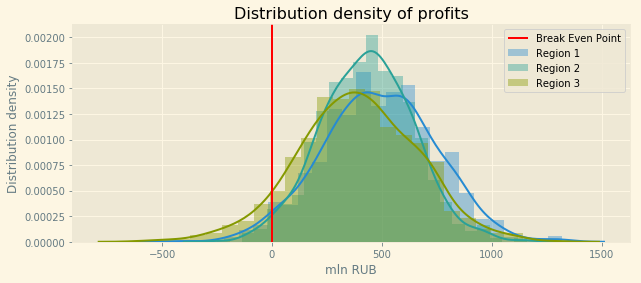

In [16]:
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(profit_1, label='Region 1')
sns.distplot(profit_2, label='Region 2')
sns.distplot(profit_3, label='Region 3')
plt.axvline(0, c='red', label='Break Even Point')
ax.set(title='Distribution density of profits', xlabel='mln RUB', ylabel='Distribution density')
ax.legend();

---

**Interim Summary:**
- the risk of losses is the smallest for Region 2; it is the only value among three region which turned out to be below the maximum allowed level of 2.5%;
- hence, this region will be recommended as a target region for wells development.

---

### 5. Final Summary <a name="paragraph5"></a>

**Data.** Three datasets, each corresponding to three regions, were provided for analysis. 

**Preparing data for analysis.** No strange or missing values were detected in the data at the preparation stage. Therefore, the datasets in their entirety were put to work.

**Model training**. Each dataset was split into a training and test sample with ratio 3:1. Linear regressions were constructed for each region-dataset separately and used to build models predicting the oil deposits using three parameters. With these models, we predicted the volume of oil in the training samples also and retained the predictions.

**Preparing calculation of expected profit:**
- We introduced key metrics: price per thousand barrels of oil, budget for total development in the region, and number of wells to be developed.
- We calculated the average minimum volume of oil reserves per well to break even: 111 thousand barrels. 
- This is 14-49% higher than the average oil well per deposit among all regions.

**Profit calculation:**
- We created a profit calculation function that takes a list of wells, ranks them by predicted oil reserves, and counts the profit for the first 200 wells based on the actual oil reserves in them.
- Using this function, we plotted the distribution of potential profits for each region and calculated the risk of loss for each region.

**Results and recommendation:**
- The only region that demostrated am acceptable loss risk of less than 2.5% is `Region 2`.
- Accordingly, `Region 2` with 430 million rubles of potential profit and 1.9% risk of loss is recommended for development.

-------------

End of the notebook